![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importación librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

from flask import Flask
from flask_restx import Api, Resource, fields

In [2]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [ ]:
# Visualización datos de entrenamiento
print(dataTraining.info())
dataTraining.head()

In [ ]:
# Visualización datos de test
print(dataTesting.info())
dataTesting.head()

In [4]:
def grafica_distribucion(df: pd.DataFrame):
    '''
    '''
    df_num = df.select_dtypes(exclude=[object]).copy()
    df_cat = df.select_dtypes(include=[object]).copy()

    var_num = df_num.columns.to_list()
    col = len(var_num)
    fig, axes = plt.subplots (1,col,figsize = (18,4))
    fig.suptitle('DISTRIBUCIÓN DE VARIABLES NUMERICAS')

    for i,j in enumerate (var_num):
        data = df_num[j]
        axes[i].hist(data,bins = 37,color = "green",alpha = 0.65, rwidth = 0.85);
        axes[i].set_xlabel(f'{j}')
        axes[1].set_ylabel('cantidad')
    
    sns.pairplot(df);
    

    var_cat= df_cat.columns.to_list()
    col = len(var_cat)
    fig, axes = plt.subplots (col,1,figsize = (17,7))
    fig.suptitle('DISTRIBUCIÓN DE VARIABLES CATAGÓRICAS')

    for i, j in enumerate(var_cat):
        data = df_cat[j].value_counts()
        sns.countplot(x=j, data=df_cat, ax=axes[i]);
        axes[i].set_xlabel(f'{j}')
        axes[i].set_ylabel('cantidad')
        axes[i].tick_params(axis='x', rotation=45,labelsize=7)

    return

def stats(df:pd.DataFrame):
    '''
    '''
    df_num = df.select_dtypes(exclude=[object]).copy()
    df_cat = df.select_dtypes(include=[object]).copy()

    for i,j in enumerate (df_cat.columns.tolist()):
        print(f'Variable: {j}')
        print(f'Cantidad de clases: {df_cat[j].nunique()}')
        print(f'Top 10 de las clases: {Counter(df_cat[j]).most_common(10)}')
        print('------------------------------------')
        
    return df_num.describe().T 

def remover(df, columns, threshold=3):
    '''
    '''
    df_no_outliers = pd.DataFrame()
    
    for column in columns:
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
        df_filtered = df[z_scores <= threshold]
        df_no_outliers = pd.concat([df_no_outliers, df_filtered], ignore_index=True)
    
    return df_no_outliers

def metrics(test,predd):
      RMSE = np.sqrt(mean_squared_error(test,predd))
      return print(f"La métrica de evaluación del modelo regresión es:\nRMSE : {RMSE:,.3f}")

In [ ]:
#stats(dataTraining)

In [ ]:
#grafica_distribucion(dataTraining)

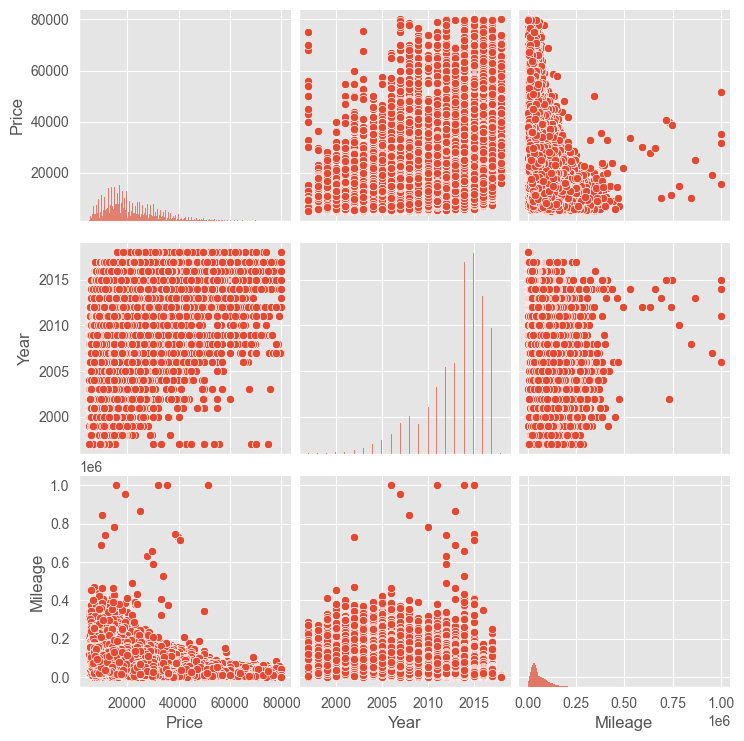

In [23]:
dataTraining_noo = remover(dataTraining, ['Mileage'], threshold=30)
sns.pairplot(dataTraining_noo);

In [24]:
X = dataTraining_noo.drop(['Price'], axis=1)
y = dataTraining_noo['Price']

data_num = X.select_dtypes(exclude=[object]).copy()
data_cat = X.select_dtypes(include=[object]).copy()

scaler = StandardScaler()
data_num_scaled = scaler.fit_transform(data_num)

#decomposer = PLSRegression(n_components=2).fit(data_num_scaled,y)
#data_num_pls = decomposer.transform(data_num_scaled)

decomposer = PCA(n_components=2).fit(data_num_scaled)
data_num_pca = decomposer.transform(data_num_scaled)

for i in data_cat.columns:
    data_cat[i] = data_cat[i].astype('category')

#data_cat_encoded = pd.get_dummies(data_cat,columns=data_cat.columns, drop_first=True)
encoder = OneHotEncoder(handle_unknown='ignore', drop='first').fit(data_cat)
data_cat_encoded = encoder.transform(data_cat).toarray()


In [25]:
X_Training = np.concatenate((data_num_pca, data_cat_encoded), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_Training, y, test_size=0.20, random_state=42)

#X_train = pd.DataFrame(X_train, columns=['PLS1', 'PLS2'] + data_cat_encoded.columns.tolist())
#X_test = pd.DataFrame(X_test, columns=['PLS1', 'PLS2'] + data_cat_encoded.columns.tolist())

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((319998, 613), (80000, 613), (319998,), (80000,))

In [26]:
params = {'learning_rate': 0.8054054054054054,
           'n_estimators': 244,
           'max_depth': 6,
           'max_leaves': 37, 
           'subsample': 1.0, 
           'colsample_bytree': 1.0,
           'gamma': 0.0, 
           'reg_alpha': 0.10204081632653061}

model_xgb = XGBRegressor(objective ='reg:squarederror', eval_metric='rmse',random_state=42, n_jobs=-1, ** params)

model_xgb.fit(X_train, y_train)
prediction = model_xgb.predict(X_test)

metrics(y_test, prediction)

La métrica de evaluación del modelo regresión es:
RMSE : 3,574.486


In [21]:
dataTraining_ = remover(dataTraining, ['Mileage'], threshold=30)

X_ = dataTraining_.drop(['Price'], axis=1)
y_ = dataTraining_['Price']

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.20, random_state=42)

data_num = X_.select_dtypes(exclude=[object]).copy()
data_cat = X_.select_dtypes(include=[object]).copy()

num_pipeline = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components=2))])
cat_pipeline = Pipeline([('encoder', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer([('numerical', num_pipeline, data_num.columns),('categorical', cat_pipeline, data_cat.columns)])

params = {
    'learning_rate': 0.8054054054054054,
    'n_estimators': 244,
    'max_depth': 6,
    'max_leaves': 28, 
    'subsample': 1.0, 
    'colsample_bytree': 1.0,
    'gamma': 0.0, 
    'reg_alpha': 0.10204081632653061}

cars_pipeline = Pipeline([('preprocessor', preprocessor),('model', XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42, n_jobs=-1, **params))])
cars_pipeline.fit(X_train_, y_train_)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  Index(['Year', 'Mileage'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['State', 'Make', 'Model'], dtype='object'))])),
                ('model',
                 XGBRegressor(base_score=...
                              feature_types=None, gamma=0.0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.8054054054054054, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=28,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=244, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [22]:
cars_prediction = cars_pipeline.predict(X_test_)
metrics(y_test_, cars_prediction)

La métrica de evaluación del modelo regresión es:
RMSE : 3,601.031


In [ ]:
app = Flask(__name__)

# Definición API Flask
api = Api(
    app, 
    version='0.0a', 
    title=' Pre-own Car Price Prediction API',
    description='API for prediction of pre-own cars in USA. Developed by Team 8.')

ns = api.namespace('predict', 
     description='Phishing Classifier')

# Definición argumentos o parámetros de la API
parser = api.parser()
parser.add_argument(
    'URL', 
    type=str, 
    required=True, 
    help='URL to be analyzed', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})